In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real.shape

(2016, 75)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

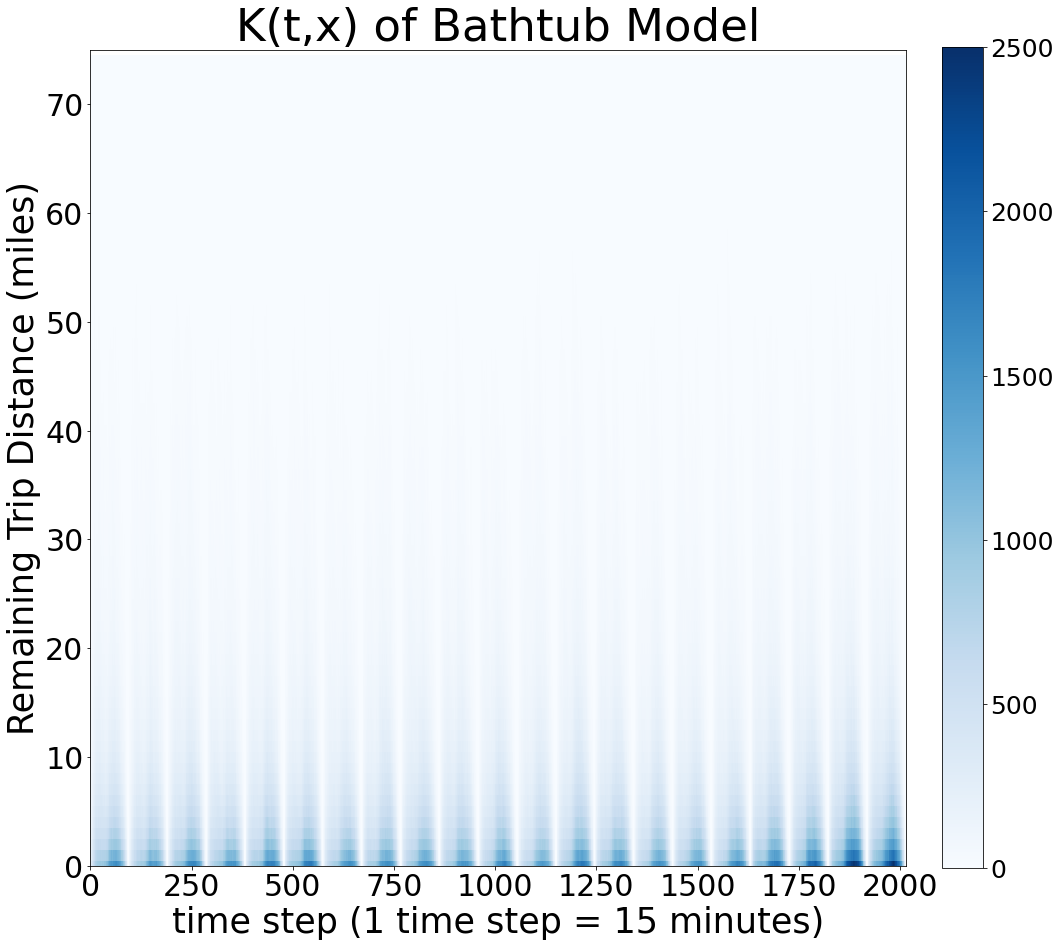

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 1 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  75600
N_u =  15120
N_f =  30240


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(15120, 2)

In [12]:
X_u_test.shape

(60480, 2)

In [13]:
X_u_train

array([[0.40540541, 0.31364764],
       [0.45945946, 0.35037221],
       [0.67567568, 0.81885856],
       ...,
       [0.17567568, 0.97866005],
       [0.32432432, 0.54094293],
       [0.63513514, 0.21736973]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0028801102936232377 0.0050499228939217666 0.00071029769332470855 0.7824360720848788
0.002838007566026801 0.0050368644512130845 0.00063915068084051722 0.7811637355663451
0.0028124409661997064 0.0050374088220343323 0.0005874731103650805 0.7809382773075219
0.0027830462919980984 0.0050130139600031735 0.00055307862399302341 0.778812284579551
0.0027083563420232009 0.0049250696954589012 0.00049164298858750052 0.7714249859910307
0.002634260860496894 0.0048442954737564657 0.00042422624723732218 0.7645173348335896
0.0025730036655494844 0.0048105795848611341 0.0003354277462378351 0.7618024715367593
0.0025427645013611968 0.0047972087126305751 0.00028832029009181819 0.7609213223773511
0.0025330747212684458 0.004792741653642258 0.00027340778889463335 0.7608567083051103
0.0025224669989947456 0.0047899521462255058 0.00025498185176398567 0.760968139679501
0.0025170576717213245 0.0047887709926218627 0.00024534435082078663 0.761020183496597
0.0025119553392854268 0.0047865788436153344 0.0002373318349555

0.0015759715972067383 0.0026816364665030921 0.00047030672791038445 0.5802637028095321
0.0015758898643394542 0.0026811887100426047 0.00047059101863630362 0.580189206019735
0.001575864788307125 0.00268160142954334 0.00047012814707090992 0.580216462272069
0.0015758419832929706 0.00268259064683674 0.00046909331974920125 0.5803067957821328
0.0015758346425603575 0.0026830239821308477 0.00046864530298986736 0.5803480578659302
0.0015758211903889742 0.0026829239966137688 0.00046871838416417949 0.5803306075169175
0.001575801349094822 0.002682921811511957 0.00046868088667768675 0.5803187851394757
0.0015757885313380958 0.0026826802374953335 0.000468896825180858 0.5802825916721747
0.0015757727159016735 0.0026826534464900447 0.000468891985313302 0.5802698136426344
0.0015757459457653106 0.0026827601935634623 0.00046873169796715874 0.5802681455353741
0.0015756687699848989 0.0026826561293293335 0.00046868141064046405 0.5802318636935512
0.0015755483829505825 0.0026830186654741824 0.00046807810042698235 

0.0015705159939370633 0.0026709525258301488 0.00047007946204397755 0.5788998079415685
0.0015704986397661661 0.002669784268543994 0.00047121301098833823 0.5787668495479817
0.0015704603015882349 0.0026694255862671767 0.0004714950169092933 0.5787312450323181
0.0015704112809995952 0.0026698041464494403 0.00047101841554975007 0.5787744435642455
0.0015703966683975588 0.0026695297442097875 0.00047126359258533034 0.5787349817772981
0.0015703575445395776 0.0026690206137563845 0.00047169447532277061 0.5786820813553513
0.001570334601983879 0.0026682490258914124 0.00047242017807634542 0.5786234994300294
0.0015703255630269573 0.0026673742722723268 0.00047327685378158781 0.5785251925253757
0.0015703146047475187 0.0026669029209708231 0.00047372628852421439 0.5784738429225262
0.0015703032754932353 0.0026674158468761346 0.00047319070411033629 0.5785401059312449
0.0015702988934616362 0.0026668755136000353 0.00047372227332323686 0.5784894624684188
0.0015702963564947782 0.0026671055736672312 0.00047348713

0.001569563730223383 0.0026673097054562278 0.00047181775499053827 0.5784131168010065
0.0015695467766900094 0.0026695382668739174 0.00046955528650610153 0.578654352630966
0.0015695380789597841 0.00266987583201684 0.00046920032590272827 0.5787002226660347
0.0015695267904398014 0.0026690282510657987 0.00047002532981380414 0.5785872874778468
0.0015695172228188793 0.0026693362946358687 0.00046969815100188992 0.5786199886658351
0.0015695050187612297 0.00266998930874446 0.00046902072877799949 0.5786925553879934
0.0015694840782896321 0.0026704272698902026 0.00046854088668906162 0.5787376857320343
0.001569450240234857 0.0026708035165989479 0.00046809696387076617 0.578783451947411
0.0015694267479408391 0.0026703185724194522 0.00046853492346222612 0.5787220713243995
0.0015694035233399255 0.002667402531080033 0.00047140451559981797 0.5784031290980546
0.0015693528871794683 0.0026683136122094236 0.00047039216214951287 0.5784990321121934
0.0015693402787570507 0.0026687060772999731 0.00046997448021412

0.0015689252641107954 0.0026666972826827335 0.00047115324553885724 0.5782435990883359
0.0015689157021485797 0.00266671271728984 0.0004711186870073196 0.5782385930170193
0.0015689127829236612 0.0026666547757938043 0.0004711707900535183 0.5782338576488991
0.0015689027456221171 0.0026672793782931748 0.00047052611295105907 0.5783070832549152
0.0015688975545058283 0.0026667532198251464 0.00047104188918651018 0.5782511305711361
0.0015688917184017003 0.0026665626723093357 0.00047122076449406479 0.5782464467493971
0.0015688903015790079 0.0026663967276711153 0.00047138387548690039 0.5782209704184593
0.0015688897011882971 0.0026663219052006403 0.00047145749717595389 0.5782128325191811
0.0015688881790007756 0.002666787408312271 0.00047098894968928043 0.578264245605874
0.0015688858235072206 0.0026670713737888376 0.00047070027322560382 0.5782957179832878
0.0015688831303619761 0.0026674666097574224 0.00047029965096652963 0.578339386846904
0.0015688785550123905 0.0026672744645902797 0.000470482645434

0.0015678523865137687 0.0026645345530821756 0.00047117021994536187 0.5778170253883669
0.0015678419601068549 0.0026644316944112495 0.00047125222580246003 0.5778012644554439
0.0015678276459401253 0.0026641382650434229 0.00047151702683682792 0.5777633823047903
0.0015678121780470559 0.0026640577573212774 0.0004715665987728343 0.5777619122628527
0.0015677996722864326 0.0026643402288362124 0.00047125911573665281 0.5777891936940149
0.0015677938409216201 0.0026639521381427249 0.00047163554370051525 0.5777496252770152
0.001567783426211901 0.0026633590782675683 0.00047220777415623335 0.5776974765711362
0.0015677716216024409 0.0026631756802921159 0.00047236756291276611 0.5776717213942063
0.0015677657247421767 0.0026623129898132344 0.00047321845967111895 0.5776003696044922
0.0015677484785445702 0.0026625662188342371 0.00047293073825490311 0.5776206566208695
0.0015677406232898815 0.0026628648059516496 0.00047261644062811334 0.5776470528057492
0.0015677334027490613 0.0026638053950299636 0.0004716614

0.0015673496458844089 0.0026653969140939971 0.00046930237767482083 0.5779359156189512
0.001567347723392109 0.0026653378706761308 0.00046935757610808718 0.5779238561383688
0.0015673450291451866 0.0026650831513641083 0.00046960690692626517 0.5778964579709658
0.0015673383405288002 0.0026648557102519959 0.00046982097080560433 0.5778666551038933
0.0015673350168569444 0.0026649471234645719 0.00046972291024931695 0.5778792009754345
0.0015673321837211119 0.0026652948333588536 0.00046936953408337006 0.5779288819789541
0.0015673304090061144 0.0026653371732166336 0.00046932364479559512 0.5779345017191724
0.0015673281190778468 0.0026649144413546082 0.00046974179680108543 0.5778962707093028
0.001567326649177637 0.0026651824840799362 0.00046947081427533785 0.5779253080553248
0.0015673250669394783 0.0026652652398525684 0.00046938489402638828 0.5779355510726488
0.0015673225184625467 0.0026653948770018429 0.00046925015992325069 0.5779510928202148
0.0015673163137924111 0.0026649368567498695 0.0004696957

0.0015662480029325458 0.0026675164597317088 0.00046497954613338284 0.5782218185918494
0.0015662344916895867 0.0026676221409048851 0.00046484684247428824 0.5782303434380862
0.0015661882173588926 0.002667063300410577 0.0004653131343072085 0.5781504229629159
0.0015661344282079663 0.0026684635765572128 0.00046380527985871961 0.578298747801442
0.0015661077236422424 0.0026679306341032103 0.00046428481318127473 0.5782321256628056
0.0015660473192813309 0.0026667646741704971 0.00046532996439216465 0.5781007991976683
0.0015660134611479378 0.0026666741653648828 0.00046535275693099281 0.5780910918081306
0.0015659464091670528 0.0026643973509301571 0.00046749546740394867 0.5778501158714856
0.0015659213615502098 0.0026667334964012423 0.00046510922669917713 0.5781005566260998
0.0015659039670175544 0.0026697072406229126 0.00046210069341219616 0.5784069272817468
0.0015658788691858294 0.0026684317962775775 0.000463325942094081 0.578283768256623
0.0015658680374593008 0.0026664720746546289 0.00046526400026

0.0015581830128357592 0.0026537690756465843 0.00046259695002493433 0.5767837406769499
0.0015580994989682763 0.0026519484129849634 0.0004642505849515891 0.5766492304822038
0.0015580260032317032 0.0026525921153505859 0.0004634598911128203 0.5766479107807845
0.0015579686428659836 0.0026537332452438063 0.00046220404048816108 0.5767095040134264
0.0015578584251460502 0.0026544508091442642 0.000461266041147836 0.5768228319464991
0.0015577699111556016 0.002654576623370839 0.00046096319894036407 0.5768465973234207
0.00155766426222805 0.0026559393475927835 0.00045938917686331662 0.5769586083692148
0.0015575897510845815 0.0026567533646667074 0.00045842613750245572 0.5770701423198936
0.0015574979278773458 0.0026563601016487692 0.00045863575410592234 0.5770517037337278
0.0015574259490421685 0.0026546701462455365 0.00046018175183880063 0.5768572259310212
0.0015573902383067273 0.0026527593138711953 0.00046202116274225908 0.5767176377580759
0.0015573430904134915 0.0026530950796511237 0.000461591101175

0.0015549671164800424 0.0026479695298016605 0.00046196470315842437 0.5762271583211933
0.0015549632350891039 0.0026475533966735577 0.00046237307350465009 0.5761829488890013
0.0015549571396459533 0.0026472051245704994 0.00046270915472140724 0.5761432495144433
0.0015549457286540579 0.0026470411061677904 0.00046285035114032526 0.5761187349949621
0.001554929610036726 0.0026466960087161442 0.00046316321135730785 0.5760826086415538
0.0015549058117693012 0.0026470017109417872 0.000462809912596815 0.5760929960150043
0.0015548882228010594 0.0026460231149672145 0.00046375333063490435 0.5760110661023568
0.0015548462146671934 0.0026483800494218855 0.00046131237991250149 0.5762541772554016
0.0015548145800596113 0.0026474268772454109 0.00046220228287381188 0.5761427651748251
0.0015547756385366931 0.0026484999172160188 0.00046105135985736746 0.5762578007022722
0.0015547320775320551 0.0026473981853423838 0.00046206596972172648 0.5761752115839629
0.0015546875284400035 0.0026485983459387688 0.00046077671

0.0015516848720531081 0.0026457577352464175 0.00045761200885979862 0.5761034807021688
0.0015516525275963591 0.0026460130008923014 0.00045729205430041685 0.5761255438318065
0.0015516010132788432 0.0026452013326162711 0.00045800069394141542 0.5760301860510056
0.00155156603439232 0.002645594544381227 0.00045753752440341316 0.5760820494185142
0.0015515330579186756 0.00264541396615507 0.00045765214968228123 0.5760601604988688
0.0015515179351482723 0.0026444466418963819 0.00045858922840016268 0.5759635519281755
0.0015515012948020244 0.0026449749534432875 0.0004580276361607615 0.5760202158615532
0.0015514843083482938 0.002644974508948 0.00045799410774858743 0.5760119846215921
0.0015514727584828793 0.0026444891516306844 0.00045845636533507414 0.5759591814695392
0.0015514563214114427 0.0026446721502895185 0.000458240492533367 0.5759756270666896
0.0015514370264170204 0.0026433283961959822 0.00045954565663805855 0.5758148296322952
0.0015514260943396765 0.0026443806724543817 0.00045847151622497142

0.0015505746222821909 0.0026440804084809783 0.00045706883608340377 0.5758065528586439
0.0015505698310505688 0.0026439569125867807 0.00045718274951435693 0.5757893253545122
0.001550563908787926 0.0026426673530348496 0.0004584604645410024 0.5756640783149377
0.0015505513720413997 0.0026434930859215939 0.00045760965816120565 0.5757487923043825
0.0015505420224334293 0.0026441053540028512 0.00045697869086400747 0.5758061883612732
0.0015505381452608842 0.0026443085893723406 0.0004567677011494277 0.5758408131964504
0.0015505289094670679 0.0026440732466641065 0.00045698457227002912 0.5758094545564285
0.001550524189120118 0.0026441430280377543 0.00045690535020248183 0.5758151781603736
0.0015505176719572116 0.0026436574252679391 0.00045737791864648426 0.5757604974130885
0.0015505099828062652 0.0026444576673982866 0.000456562298214244 0.5758511969797889
0.0015505060334929559 0.0026447136004659347 0.00045629846651997706 0.5758723413091169
0.0015504964213261493 0.0026441379919605081 0.00045685485069

0.0015498362647104848 0.0026421680612005063 0.00045750446822046345 0.5755642798703605
0.0015498096382442544 0.0026427330890742575 0.0004568861874142511 0.5756113008996032
0.0015497826097169189 0.0026435204558883786 0.00045604476354545897 0.5757020040465641
0.0015497655086894823 0.0026428303490120078 0.0004567006683669566 0.5756112365234455
0.0015497600116378793 0.0026401930799101023 0.00045932694336565634 0.5753087431255286
0.0015497412393258598 0.0026416831549622068 0.00045779932368951296 0.5754658500362053
0.0015497266988910613 0.0026426569648325539 0.00045679643294956892 0.5755685355970084
0.0015497086107236927 0.0026428396018801947 0.00045657761956719069 0.575592928479468
0.0015497030528136468 0.0026436983474062859 0.00045570775822100775 0.5756842596902474
0.0015496812890226214 0.0026410636704664722 0.00045829890757877054 0.5754085910639154
0.0015496729530440508 0.0026412852767371069 0.00045806062935099454 0.5754370490586619
0.0015496576684403333 0.0026411341828245821 0.00045818115

0.0015480467495584856 0.0026394868432113952 0.00045660665590557619 0.5754711127709364
0.0015480164377090488 0.0026381409414337025 0.00045789193398439512 0.5753343942712897
0.0015479773829365408 0.002636427652680583 0.00045952711319249888 0.575143611748263
0.001547943378891804 0.0026369170032164218 0.00045896975456718623 0.5751962413268884
0.0015479184372789905 0.0026360164792981113 0.00045982039525986975 0.5750972829831096
0.0015478914910194187 0.00263779904595399 0.00045798393608484757 0.57526547775986
0.0015478637776850793 0.0026372909725236792 0.00045843658284647947 0.5752493958146241
0.0015478384686151939 0.0026357783636459706 0.00045989857358441719 0.575088317889377
0.0015478145916908311 0.0026357908238128164 0.000459838359568846 0.5750729612304387
0.0015477940077035064 0.0026360171451802069 0.00045957087022680584 0.5750970473768447
0.001547777093149484 0.0026372371691922632 0.00045831701710670453 0.5752243028756756
0.001547763949357383 0.0026370195068679981 0.00045850839184676786

0.0015449536376105409 0.0026306817876495933 0.00045922548757148867 0.5745176752888548
0.0015448923304739266 0.0026329635919701655 0.00045682106897768765 0.5747550040563381
0.001544845573347184 0.0026329475861940252 0.00045674356050034244 0.5747631520829368
0.0015448338066245751 0.0026335159175754565 0.0004561516956736938 0.5748315475743175
0.0015448209634942292 0.0026327791860331563 0.000456862740955302 0.5747310491493463
0.0015447861026726497 0.0026331001484940874 0.00045647205685121214 0.5747778842996069
0.00154477009800484 0.0026326298426106263 0.00045691035339905377 0.5747207842938044
0.0015447622966406182 0.0026319739775501325 0.00045755061573110394 0.5746519132334577
0.001544750458918983 0.002631732400778426 0.00045776851705953993 0.5746294380951178
0.0015447356965363364 0.0026317575805819182 0.00045771381249075447 0.5746335454804856
0.0015447196847026619 0.0026319154046894693 0.00045752396471585461 0.5746457585205528
0.0015446984645704389 0.002631746741246064 0.00045765018789481

0.001542434305008829 0.0026301188463090041 0.0004547497637086541 0.5743899038423912
0.0015424280637315641 0.0026303124245561716 0.00045454370290695645 0.5744188337355604
0.0015424222882179425 0.00263043675619634 0.000454407820239545 0.5744311109676694
0.0015424166580043947 0.0026307922188202929 0.00045404109718849648 0.5744553485234714
0.0015424011787216077 0.0026303139453385635 0.00045448841210465191 0.5743925391287052
0.0015423883366645309 0.0026309828381616222 0.00045379383516743941 0.5744518515114144
0.0015423703656701874 0.0026321459182565218 0.00045259481308385292 0.5745494078219344
0.0015423673368753805 0.0026322100026541281 0.00045252467109663285 0.574570027473014
0.0015423486142833627 0.0026309928108756127 0.00045370441769111269 0.574437342534984
0.0015423394556290583 0.0026310546162184689 0.00045362429503964768 0.5744406885018086
0.0015423278836173512 0.0026310001501436918 0.00045365561709101031 0.5744417829605699
0.0015423237255573813 0.0026308100004015234 0.0004538374507132

0.0015382540739086921 0.0026269361070938189 0.00044957204072356533 0.5738521361919179
0.0015382370516759463 0.0026266793866792644 0.00044979471667262841 0.5738287363758906
0.0015382093496815537 0.0026267783176732364 0.00044964038168987118 0.5738583498890277
0.0015381953977763655 0.0026240816722930276 0.00045230912325970336 0.5735548005665114
0.0015381559144518 0.0026245789659075148 0.00045173286299608507 0.5736264197197316
0.0015381176015621517 0.002626348691559954 0.00044988651156434962 0.5738251468578867
0.0015380875400473621 0.002626596841216505 0.00044957823887821941 0.5738300197820018
0.00153806574822967 0.0026261783164688345 0.00044995317999050547 0.5737652728126553
0.0015380357306296513 0.0026261495714342076 0.00044992188982509478 0.5737705769160151
0.0015379939089574556 0.0026247807020565225 0.0004512071158583886 0.5736331946879064
0.0015379294460724688 0.0026243160622163239 0.00045154282992861366 0.5735870674346955
0.0015378732697607293 0.002622386674214524 0.00045335986530693

0.0015346866179357767 0.0026227552749122987 0.00044661796095925478 0.5732402807186275
0.0015346466405433549 0.0026228194617953829 0.00044647381929132691 0.5732500257273537
0.0015345969927493173 0.002623261876880376 0.00044593210861825839 0.5732945153262944
0.001534498048388914 0.0026237406918238585 0.00044525540495396959 0.5733335507232353
0.0015344351826023432 0.002624655944109737 0.00044421442109494956 0.5734330463962584
0.0015344024401213316 0.0026250774505702573 0.000443727429672406 0.5734437077216752
0.0015343642418267555 0.0026240530166479264 0.0004446754670055846 0.5733471291007844
0.0015343447945446477 0.002623830998410368 0.00044485859067892739 0.5733195665418851
0.0015343185612305735 0.0026239976269216508 0.00044463949553949636 0.5733253294639291
0.0015342813055529872 0.0026236082750372034 0.00044495433606877075 0.5732690057869921
0.0015342380070902969 0.0026231953224334545 0.00044528069174713927 0.5732103588181201
0.0015341420338598677 0.0026228468955122887 0.000445437172207

0.0015304533644670711 0.0026188629773127394 0.00044204375162140263 0.5728454143617803
0.0015303814797487409 0.0026177658708053993 0.00044299708869208247 0.5727351633223495
0.0015303248515578457 0.002617686878819856 0.00044296282429583551 0.5727226247592713
0.0015303065148023131 0.0026181222847330315 0.00044249074487159477 0.5727571995170687
0.0015302714464643784 0.0026177153619813 0.00044282753094745676 0.5727198288602212
0.0015302404176753125 0.0026187269053854229 0.00044175392996520215 0.5728278885542514
0.001530222941971201 0.00261851347092209 0.00044193241302031204 0.572809440773091
0.001530197230740864 0.0026188233666363304 0.00044157109484539736 0.5728477189502743
0.0015301758683164694 0.0026190133237085525 0.00044133841292438636 0.5728703391684083
0.0015301515986677222 0.002618139697596545 0.00044216349973889949 0.5727822773430882
0.001530128942728113 0.0026182976939529844 0.00044196019150324141 0.5727937649018866
0.0015301173891314388 0.0026179138353941895 0.0004423209428686879

0.0015286851717477602 0.0026179650371421859 0.00043940530635333476 0.5726915923115613
0.0015286795930921904 0.0026179516109420282 0.00043940757524235272 0.5726936437724055
0.0015286727447222587 0.0026179002322150036 0.00043944525722951379 0.5726915148640274
0.0015286698811584742 0.0026179389943580553 0.000439400767958893 0.5727002581234066
0.0015286602340335771 0.0026179212902558572 0.00043939917781129719 0.5727003820253486
0.0015286540435517713 0.0026182663193598222 0.00043904176774372026 0.5727292188545197
0.0015286506723604322 0.0026183553871311875 0.000438945957589677 0.5727425657818307
0.00152864455580996 0.00261842713856162 0.00043886197305829992 0.5727485067300776
0.0015286406879071767 0.0026183957520252697 0.00043888562378908356 0.5727427131641069
0.0015286366355353452 0.002618562917689281 0.00043871035338140913 0.5727623660352089
0.0015286346063218494 0.0026183142293958145 0.00043895498324788429 0.5727315636171393
0.0015286315651572514 0.0026182309482532724 0.00043903218206123

0.0015274833385378129 0.0026153925440773342 0.00043957413299829145 0.5725314194248591
0.0015274788802991965 0.0026150793565096527 0.00043987840408874027 0.5724930581720235
0.0015274763171230139 0.0026150364872961191 0.00043991614694990883 0.5724750155312063
0.001527470075495438 0.0026156968744762356 0.00043924327651464047 0.5725520015847657
0.001527466972571176 0.0026154915328532443 0.0004394424122891076 0.5725300213464929
0.0015274654895865297 0.0026156853762626057 0.00043924560291045366 0.5725488087886358
0.0015274591265182404 0.0026149619819442532 0.00043995627109222769 0.5724722695211106
0.0015274558316396485 0.0026152860676464896 0.00043962559563280742 0.572520722545169
0.00152744602197197 0.0026146570632623492 0.000440234980681591 0.5724552273240537
0.0015274422168719689 0.0026147904471992044 0.00044009398654473324 0.5724689248100167
0.0015274386616984797 0.0026146437209824654 0.00044023360241449388 0.5724579497762008
0.0015274324790719221 0.0026152440245259924 0.0004396209336178

0.0015268347841910568 0.0026143847957880288 0.00043928477259408486 0.5724228668497369
0.0015268237558891441 0.0026153268850735343 0.000438320626704754 0.5725159554262859
0.0015268183287027121 0.0026151819818519017 0.00043845467555352242 0.5725009361234029
0.0015268132088072316 0.0026146127975523814 0.00043901362006208185 0.572436841547746
0.0015268071195661443 0.0026146633362610135 0.0004389509028712751 0.5724457587748933
0.0015267999289716643 0.0026147839735727063 0.00043881588437062226 0.57245790741054
0.0015267939670766863 0.0026147805787060064 0.00043880735544736619 0.5724567385454766
0.0015267841303389946 0.0026145325031896455 0.00043903575748834386 0.5724306063228062
0.0015267750449087679 0.0026138533135329992 0.00043969677628453649 0.572366950875478
0.0015267697666815098 0.0026143931808663414 0.00043914635249667829 0.5724157948054316
0.0015267661602722622 0.002614561847243407 0.00043897047330111727 0.5724327330236908
0.0015267630260915837 0.0026142078106801843 0.0004393182415029

0.0015258878496381323 0.0026130440490031858 0.0004387316502730787 0.5723123309280579
0.001525883142587912 0.002613565079049703 0.0004382012061261211 0.5723636037602927
0.0015258767878963159 0.0026134881331149524 0.00043826544267767936 0.572355264333406
0.00152586674102278 0.0026136460613519095 0.00043808742069365052 0.5723788524622567
0.0015258581789928574 0.0026139933714338765 0.00043772298655183836 0.5724077314697619
0.0015258427198316514 0.0026138369949637763 0.00043784844469952646 0.5723934915465183
0.0015258206648413903 0.0026143723115802297 0.00043726901810255088 0.5724496454527174
0.001525810216704439 0.0026130873481931141 0.00043853308521576355 0.5723307880833879
0.0015257905029607054 0.0026139797752112092 0.00043760123071020151 0.5724138904593126
0.0015257815208198039 0.0026147195884600408 0.00043684345317956675 0.5724909594849978
0.0015257679342579691 0.0026134196852495867 0.00043811618326635164 0.572349668491349
0.00152574965734569 0.0026128290069570548 0.0004386703077343252

0.0015243238668503315 0.0026118460527527775 0.00043680168094788538 0.5722074100790293
0.0015243008922912523 0.0026121694834709964 0.00043643230111150834 0.5722384786556987
0.0015242624887021868 0.0026114361946825227 0.0004370887827218509 0.572157021311813
0.0015242447652092912 0.0026124560988657337 0.00043603343155284885 0.5722688366527062
0.0015242188180575322 0.0026117733428924548 0.00043666429322260941 0.5721919400051603
0.001524200853403031 0.0026123142075423112 0.00043608749926375083 0.5722385133942968
0.0015241896302827696 0.0026133986892369725 0.00043498057132856683 0.5723460057008545
0.0015241731673573827 0.0026119228423856 0.00043642349232916525 0.5721995925834225
0.0015241560755367 0.0026128825451005849 0.000435429605972815 0.5723016936399791
0.0015241362360907563 0.0026124894157018635 0.00043578305647964895 0.5722449178694264
0.0015241268278618531 0.002613096480778827 0.00043515717494487909 0.5723188798724461
0.0015241158346896522 0.0026124508370183076 0.00043578083236099662

0.001522812794578625 0.0026097794353676287 0.00043584615378962149 0.5720015575136359
0.0015227836189515517 0.0026095788112945489 0.00043598842660855431 0.5719908224600669
0.0015227481927236918 0.0026095928580193721 0.00043590352742801149 0.5719795174900099
0.0015227062000506095 0.0026073739235645751 0.00043803847653664394 0.5717564137740228
0.0015226881115618265 0.0026107922587206129 0.00043458396440304006 0.5721505379880836
0.001522653422434054 0.0026099254126251319 0.000435381432242976 0.5720736482514533
0.0015226178230060578 0.0026078361417473292 0.0004373995042647866 0.5718483659826541
0.001522600189126803 0.0026081732888908297 0.00043702708936277612 0.5718954137168173
0.0015225659003088069 0.002607361688451184 0.00043777011216642971 0.5718020015547809
0.0015225462411027585 0.002607316747197851 0.00043777573500766584 0.5717808583094025
0.0015225102120569258 0.0026088257060115582 0.00043619471810229328 0.5719473763237236
0.0015224809027737591 0.00260765365779479 0.000437308147752728

0.0015210230997855783 0.0026073790161830895 0.00043466718338806696 0.5716985135623224
0.0015210122580518412 0.0026076893605227608 0.00043433515558092168 0.5717297755870917
0.0015210023158768156 0.0026071476264354796 0.00043485700531815144 0.5716692363849275
0.0015209927449864459 0.00260723600431756 0.00043474948565533177 0.5716763304819975
0.0015209779742763744 0.0026073366711702791 0.00043461927738246972 0.5716872845259319
0.0015209657812598309 0.0026070573930221772 0.0004348741694974847 0.5716576855821781
0.0015209443033164785 0.0026065225065131786 0.00043536610011977853 0.5716059328253145
0.001520918649218017 0.0026064819800935557 0.00043535531834247853 0.5715913321972498
0.0015209005844929488 0.0026066425279726705 0.00043515864101322692 0.5716078726358886
0.0015208906083340886 0.0026070626909085121 0.00043471852575966514 0.5716421287822172
0.0015208857050703615 0.0026073522716643345 0.00043441913847638825 0.5716777400629587
0.0015208834413097574 0.002607316819830906 0.0004344500627

0.001519643444598006 0.002607104930667951 0.000432181958528061 0.5716905579997459
0.0015196397947207514 0.0026070609496618787 0.00043221863977962403 0.5716835463067472
0.0015196251469298478 0.0026073976942659017 0.00043185259959379403 0.5717079022962762
0.0015196201148236471 0.0026076625010113762 0.00043157772863591787 0.5717179505736932
0.0015196142179068862 0.0026072378823608603 0.00043199055345291196 0.5716830708319466
0.0015195959043062441 0.0026078142449176855 0.00043137756369480268 0.5717439562107305
0.0015195888047856252 0.0026071225897562112 0.00043205501981503908 0.5716688341341637
0.0015195784273434945 0.0026075873340979704 0.00043156952058901886 0.5717299738959812
0.0015195661141818699 0.0026065994481813551 0.00043253278018238464 0.5716216337320614
0.0015195556021723668 0.0026070719134126969 0.00043203929093203644 0.5716877359156003
0.0015195424462156025 0.0026070238035436318 0.00043206108888757327 0.57168679500849
0.0015195351600138574 0.0026065801422893589 0.00043249017773

0.0015188951885910143 0.0026057590418837422 0.00043203133529828646 0.5715583667053687
0.001518889329791166 0.0026058032449050978 0.00043197541467723436 0.571562965480511
0.0015188816979617864 0.0026056278871752808 0.00043213550874829208 0.571556965875686
0.001518872218104651 0.0026055198205600246 0.00043222461564927726 0.571545561122453
0.0015188647932140773 0.0026052495648390462 0.00043248002158910844 0.5715191623524162
0.0015188597223088347 0.0026050755535364828 0.00043264389108118651 0.5715022787383347
0.001518856310382169 0.0026050207270397626 0.00043269189372457527 0.5714943040901274
0.00151885343222592 0.0026050591688136968 0.000432647695638143 0.5714947152628754
0.0015188506733276954 0.002605184385850699 0.00043251696080469186 0.5715021612350808
0.0015188462837563356 0.0026055360799751765 0.00043215648753749491 0.5715331364425389
0.0015188439428289614 0.0026057966774907662 0.00043189120816715642 0.5715574067032022
0.0015188367471118379 0.0026061281282846152 0.0004315453659390606

0.0015181100557484764 0.0026050976328173612 0.00043112247867959166 0.5716139135000928
0.0015181006180959497 0.0026044944329907224 0.00043170680320117692 0.5715472540704853
0.0015180892878498772 0.0026040650611950933 0.00043211351450466123 0.5715074872529262
0.0015180841654639341 0.0026042063432847439 0.00043196198764312404 0.5715287310831721
0.0015180701697366269 0.0026042530757756483 0.00043188726369760536 0.5715349076331796
0.0015180568130048529 0.0026048381157012688 0.0004312755103084369 0.5715939679248304
0.001518044981423716 0.0026050159579295478 0.00043107400491788428 0.5716110910902839
0.0015180314131768378 0.0026042909660976381 0.00043177186025603726 0.5715300553802755
0.0015180237463082525 0.0026040432671657183 0.00043200422545078667 0.5714948883131875
0.0015180151277361341 0.0026042424366468013 0.00043178781882546684 0.5715273586933105
0.0015180064403195015 0.0026045643877758442 0.00043144849286315862 0.571556048869491
0.0015179956417839065 0.0026044869651492236 0.00043150431

0.0015172911196704964 0.0026029897380743924 0.0004315925012666004 0.5713432549827919
0.0015172604381134636 0.0026033259354751852 0.00043119494075174206 0.5713868096432947
0.0015172292258435337 0.0026040285024692628 0.00043042994921780475 0.5714819111982711
0.0015172159836645029 0.0026036054093236138 0.00043082655800539209 0.5714367931114047
0.0015172043911571864 0.0026027985209685412 0.00043161026134583128 0.5713603111100103
0.0015171957746891818 0.0026027693163543867 0.00043162223302397668 0.571351518848254
0.0015171861590308146 0.0026025024372372369 0.00043186988082439208 0.5713228233332783
0.0015171779944668086 0.0026016438346115655 0.00043271215432205175 0.5712286562521082
0.0015171691519849709 0.0026022201839500611 0.00043211812001988086 0.5712946569425585
0.0015171579282732355 0.0026027594924412961 0.000431556364105175 0.571357066167836
0.001517142858272189 0.0026034342913539865 0.00043085142519039125 0.5714351949801783
0.0015171356535998242 0.0026035981204318688 0.00043067318676

0.0015164409408675676 0.0026028226085350733 0.000430059273200062 0.5713545782433332
0.0015164197886822568 0.0026030348881056803 0.00042980468925883349 0.5713852260176178
0.0015164114316029138 0.0026029060540942385 0.00042991680911158917 0.5713793423416081
0.0015163931012417251 0.0026025065814320007 0.00043027962105144963 0.5713402421776201
0.0015163766079538848 0.0026028830841730256 0.00042987013173474394 0.5713620720062552
0.0015163620754530898 0.0026030726603997511 0.00042965149050642847 0.5713759364644387
0.001516349865743589 0.0026032639790619853 0.00042943575242519283 0.57139625053021
0.0015163437666944866 0.0026032811668919484 0.00042940636649702464 0.5714065706337756
0.0015163350092231194 0.0026029621749516806 0.00042970784349455826 0.5713757350886727
0.0015163287002594259 0.0026026964088357624 0.00042996099168308928 0.5713510399690211
0.0015163223923484396 0.0026024955613426454 0.00043014922335423371 0.5713244537566168
0.001516319338149801 0.0026024135338735131 0.00043022514242

0.0015154626763094002 0.0026018810262441838 0.00042904432637461663 0.5711945963221597
0.0015154560954779739 0.0026012894472723521 0.00042962274368359588 0.57113469962473
0.001515449157483195 0.0026013768233225472 0.0004295214916438427 0.571144381152161
0.0015154440152059024 0.0026015261756748469 0.00042936185473695814 0.5711526662537636
0.0015154381350376746 0.0026011835811708024 0.000429692688904547 0.571122182587591
0.0015154324191956527 0.0026012176084675188 0.00042964722992378668 0.5711262759555601
0.0015154194756842269 0.0026012105073973005 0.00042962844397115318 0.5711302889436599
0.0015154056240701448 0.0026012230180992753 0.00042958823004101429 0.5711343797504188
0.0015153977610835355 0.0026012417887419817 0.00042955373342508959 0.5711433366265692
0.0015153883101319218 0.0026017139879318365 0.000429062632332007 0.571187104964291
0.0015153777208846684 0.0026016846667221935 0.00042907077504714342 0.5711790090444071
0.0015153678617564686 0.002601577563228714 0.00042915816028422314

0.0015145862000516029 0.0026012253154905785 0.00042794708461262748 0.5711067801916507
0.0015145804990786688 0.0026014598156859931 0.0004277011824713443 0.5711362930315291
0.0015145740304653627 0.00260149364083077 0.00042765442009995582 0.5711356475489912
0.001514565195504897 0.002601588976769213 0.00042754141424058105 0.571142459001606
0.0015145582965406213 0.0026015537423693122 0.00042756285071193057 0.5711344158864732
0.0015145512863985939 0.0026015198371226156 0.00042758273567457207 0.5711314050512106
0.001514543969917874 0.0026013151744033172 0.00042777276543243075 0.5711139235931892
0.0015145413194200825 0.0026011156344396907 0.00042796700440047452 0.5710928173739345
0.0015145343394281083 0.002600805248738076 0.0004282634301181405 0.5710778649355415
0.001514523880365442 0.00260107949698244 0.00042796826374844418 0.5711033018891657
0.0015145136935872442 0.0026012317034298359 0.00042779568374465223 0.5711169481228625
0.0015145024423666121 0.0026012405222766723 0.00042776436245655193

0.0015137809108366222 0.002601677570702204 0.00042588425097104057 0.57110998581417
0.0015137715044130926 0.0026016711657777998 0.00042587184304838525 0.5711051909196944
0.0015137608556276955 0.002602428541341904 0.00042509316991348696 0.5711802248625486
0.0015137518021999382 0.0026025148618058118 0.00042498874259406453 0.5711926938204455
0.0015137408296159169 0.0026029987481090765 0.00042448291112275727 0.5712445342757075
0.0015137298331825179 0.0026023150912831564 0.00042514457508187927 0.5711737013493856
0.0015137197781541411 0.0026014832672068347 0.00042595628910144733 0.5711057036478179
0.0015137107049334672 0.0026013027974110749 0.00042611861245585959 0.5710800053174925
0.0015137037875051097 0.0026013298092981206 0.00042607776571209884 0.5710788682115884
0.0015136963693400591 0.0026011539009218303 0.00042623883775828777 0.5710589422322397
0.001513693488865916 0.0026011067379159156 0.00042628023981591628 0.5710593279879657
0.0015136844922321506 0.0026011231939159509 0.0004262457905

In [ ]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [ ]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()